# Descripción del Problema
Este cuaderno es parte del curso Challenge ONE Data Science Telecom. Como asistente de análisis de datos en Telecom X el desafío es recopilar, procesar y analizar los datos, utilizando Python y sus principales bibliotecas para extraer información valiosa que ayude al equipo de Data Science a avanzar en modelos predictivos y desarrollar estrategias para reducir la evasión de clientes (churn). La empresa enfrenta una alta tasa de cancelaciones y se necesita comprender los factores que llevan a la pérdida de los clientes.

In [2]:
#Importación de librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json

#📌 Extracción

In [3]:

# Cargar los datos desde el archivo JSON
url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json"

try:
    response = requests.get(url)
    response.raise_for_status() # Raise an exception for bad status codes

    # Parse the JSON content
    data = json.loads(response.text)

    print("Data extracted successfully!")
    # You can now work with the 'data' variable which contains the parsed JSON
    # print(data) # Uncomment to see the extracted data

except requests.exceptions.RequestException as e:
    print(f"Error fetching data: {e}")
except json.JSONDecodeError as e:
    print(f"Error decoding JSON: {e}")

Data extracted successfully!


In [4]:
try:
    df = pd.DataFrame(data)
    print("DataFrame created successfully!")

except Exception as e:
    print(f"Error creating DataFrame: {e}")

DataFrame created successfully!


In [5]:
df.head()

,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


In [6]:
# Ver la información general del DataFrame
print("\nInformación del DataFrame:")
df.info()


Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   customerID  7267 non-null   object
 1   Churn       7267 non-null   object
 2   customer    7267 non-null   object
 3   phone       7267 non-null   object
 4   internet    7267 non-null   object
 5   account     7267 non-null   object
dtypes: object(6)
memory usage: 340.8+ KB


#🔧 Transformación

In [7]:

# --- 1. Aplanar la estructura JSON anidada ---
# Los datos de cliente, cuenta y servicios están en columnas anidadas.
# Los aplanaremos para facilitar el acceso.

df_customer = pd.json_normalize(df['customer'])
df_account = pd.json_normalize(df['account'])
df_phone_services = pd.json_normalize(df['phone'])
df_internet_services = pd.json_normalize(df['internet'])

# Unir los dataframes aplanados en uno solo
# Add customerID and Churn from the original dataframe
df_clean = pd.concat([df[['customerID', 'Churn']], df_customer, df_account, df_phone_services, df_internet_services], axis=1)

print("DataFrame aplanado y combinado:")
print(df_clean.head())


# --- 2. Manejo de valores faltantes en 'Churn' ---
# Reemplazar valores vacíos ('') en 'Churn' con NaN para poder eliminarlos fácilmente
df_clean['Churn'] = df_clean['Churn'].replace('', np.nan)
df_clean.dropna(subset=['Churn'], inplace=True)
print(f"\nRegistros después de eliminar 'Churn' vacíos: {len(df_clean)}")


# --- 3. Conversión de 'Charges.Total' a numérico ---
# La columna 'Charges.Total' es de tipo objeto y tiene espacios en blanco
df_clean['Charges.Total'] = pd.to_numeric(df_clean['Charges.Total'], errors='coerce')
# Rellenar los valores nulos (que eran espacios) con 0.
# Esto asume que los clientes nuevos no tienen cargos totales.
df_clean['Charges.Total'].fillna(0, inplace=True)
print("\nValores nulos en 'Charges.Total' después de la limpieza:", df_clean['Charges.Total'].isnull().sum())


# --- 4. Transformar 'SeniorCitizen' a categórico ---
df_clean['SeniorCitizen'] = df_clean['SeniorCitizen'].map({0: 'No', 1: 'Sí'})
print("\nValores únicos en 'SeniorCitizen' después de la transformación:")
print(df_clean['SeniorCitizen'].unique())

print("\nLimpieza y transformación completadas.")

DataFrame aplanado y combinado:
   customerID Churn  gender  SeniorCitizen Partner Dependents  tenure  \
0  0002-ORFBO    No  Female              0     Yes        Yes       9   
1  0003-MKNFE    No    Male              0      No         No       9   
2  0004-TLHLJ   Yes    Male              0      No         No       4   
3  0011-IGKFF   Yes    Male              1     Yes         No      13   
4  0013-EXCHZ   Yes  Female              1     Yes         No       3   

         Contract PaperlessBilling     PaymentMethod  ...  Charges.Total  \
0        One year              Yes      Mailed check  ...          593.3   
1  Month-to-month               No      Mailed check  ...          542.4   
2  Month-to-month              Yes  Electronic check  ...         280.85   
3  Month-to-month              Yes  Electronic check  ...        1237.85   
4  Month-to-month              Yes      Mailed check  ...          267.4   

  PhoneService MultipleLines InternetService OnlineSecurity OnlineBackup

/tmp/ipython-input-7-1324103683.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['Charges.Total'].fillna(0, inplace=True)


#📊 Carga y análisis

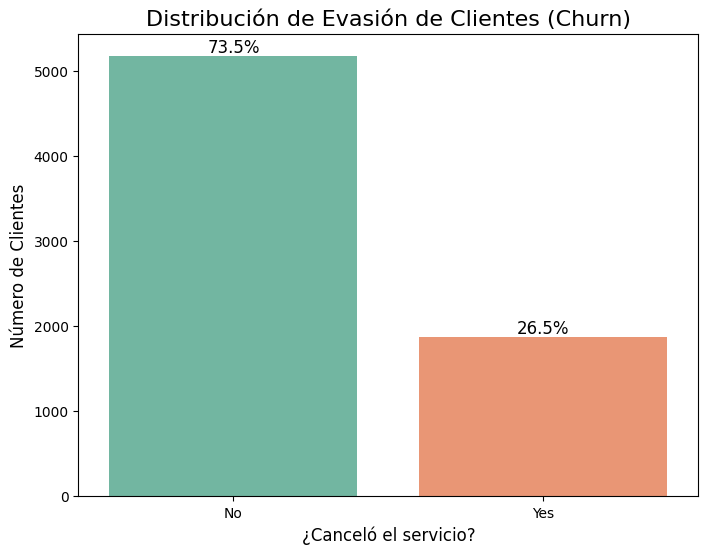

In [16]:
# Validación de la proporcion de clientes que ha cancelado el servicio.
plt.figure(figsize=(8, 6))
sns.countplot(x='Churn', data=df_clean, hue='Churn', palette='Set2', legend=False)
plt.title('Distribución de Evasión de Clientes (Churn)', fontsize=16)
plt.xlabel('¿Canceló el servicio?', fontsize=12)
plt.ylabel('Número de Clientes', fontsize=12)

# Añadir porcentajes en las barras
total = len(df_clean)
for p in plt.gca().patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    plt.gca().annotate(percentage, (x, y), ha='center', va='bottom', fontsize=12)

plt.show()

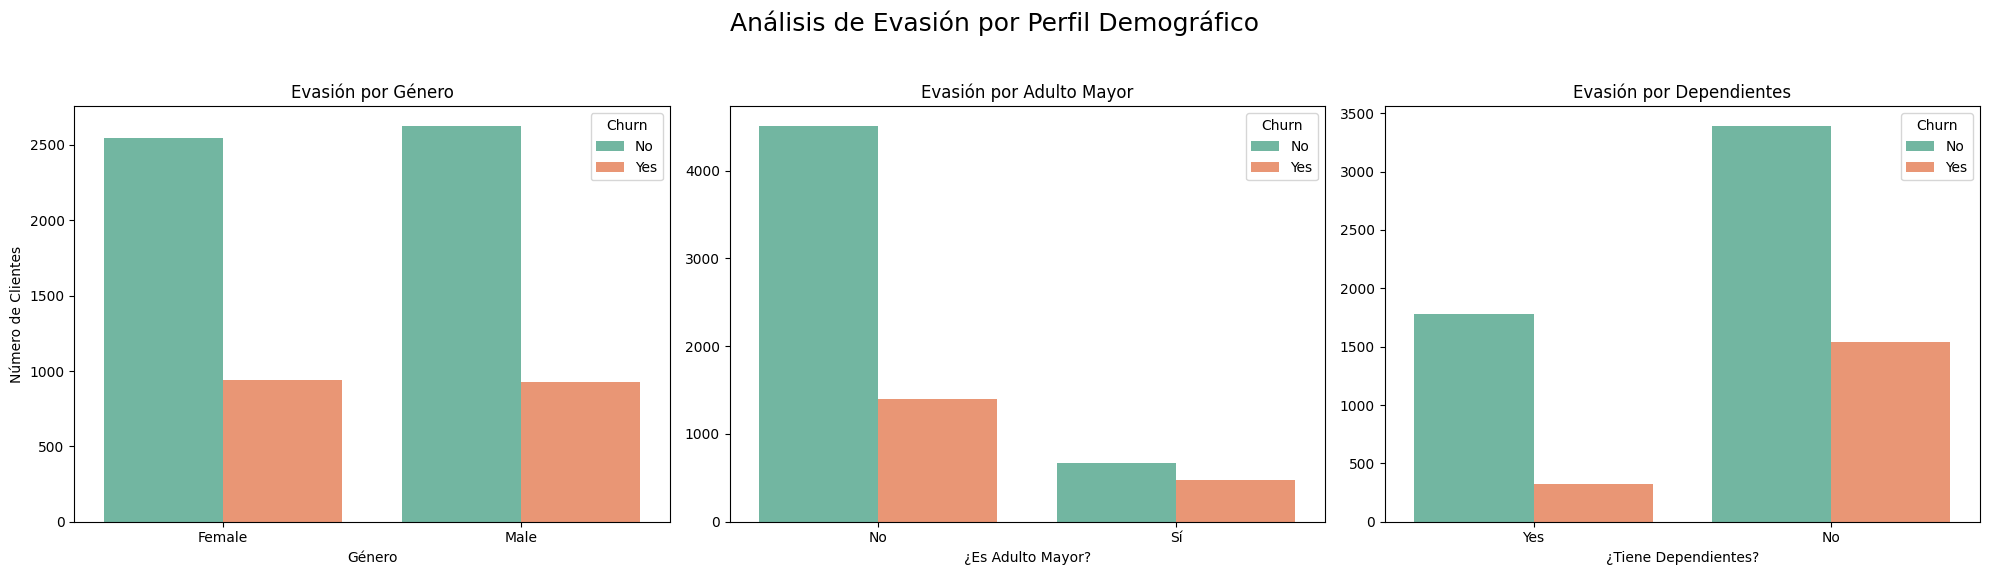

In [17]:
# Análisis por perfil demográfico del cliente
# Gráficos para analizar el churn por variables demográficas
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Análisis de Evasión por Perfil Demográfico', fontsize=18)

# Género
sns.countplot(ax=axes[0], x='gender', hue='Churn', data=df_clean, palette='Set2')
axes[0].set_title('Evasión por Género')
axes[0].set_xlabel('Género')
axes[0].set_ylabel('Número de Clientes')

# Adulto Mayor (Senior Citizen)
sns.countplot(ax=axes[1], x='SeniorCitizen', hue='Churn', data=df_clean, palette='Set2')
axes[1].set_title('Evasión por Adulto Mayor')
axes[1].set_xlabel('¿Es Adulto Mayor?')
axes[1].set_ylabel('')

# Dependientes
sns.countplot(ax=axes[2], x='Dependents', hue='Churn', data=df_clean, palette='Set2')
axes[2].set_title('Evasión por Dependientes')
axes[2].set_xlabel('¿Tiene Dependientes?')
axes[2].set_ylabel('')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

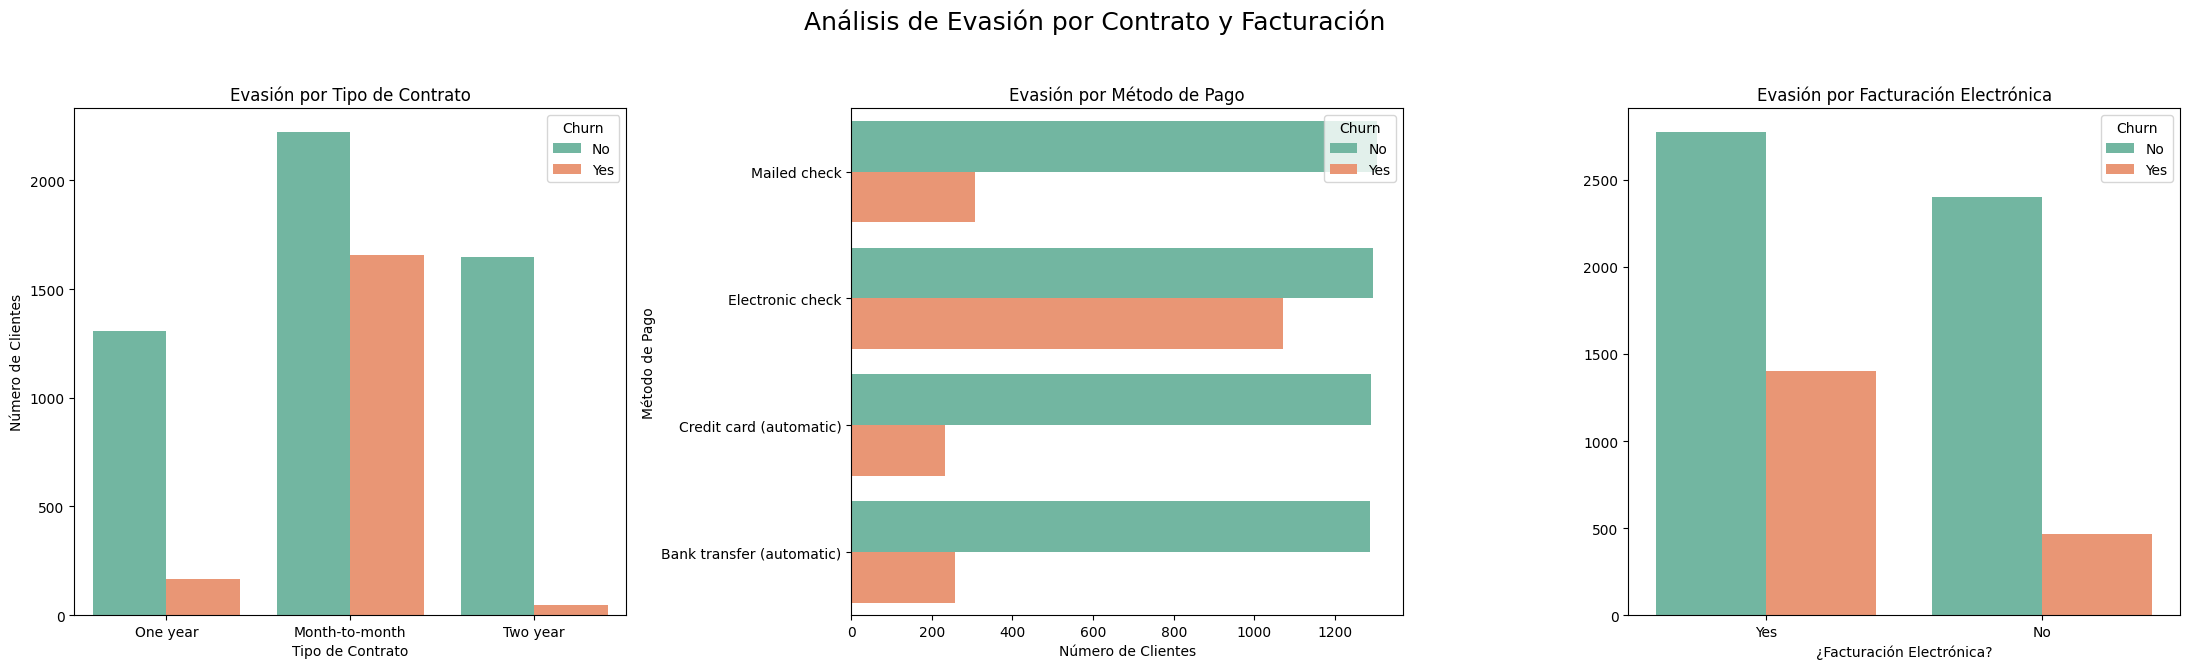

In [18]:
# Análisis por tipo de contrato y facturación
# Gráficos para analizar el churn por tipo de contrato y facturación
fig, axes = plt.subplots(1, 3, figsize=(22, 7))
fig.suptitle('Análisis de Evasión por Contrato y Facturación', fontsize=18)

# Tipo de Contrato
sns.countplot(ax=axes[0], x='Contract', hue='Churn', data=df_clean, palette='Set2')
axes[0].set_title('Evasión por Tipo de Contrato')
axes[0].set_xlabel('Tipo de Contrato')
axes[0].set_ylabel('Número de Clientes')

# Método de Pago
sns.countplot(ax=axes[1], y='PaymentMethod', hue='Churn', data=df_clean, palette='Set2')
axes[1].set_title('Evasión por Método de Pago')
axes[1].set_xlabel('Número de Clientes')
axes[1].set_ylabel('Método de Pago')

# Facturación sin papel (Paperless Billing)
sns.countplot(ax=axes[2], x='PaperlessBilling', hue='Churn', data=df_clean, palette='Set2')
axes[2].set_title('Evasión por Facturación Electrónica')
axes[2].set_xlabel('¿Facturación Electrónica?')
axes[2].set_ylabel('')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

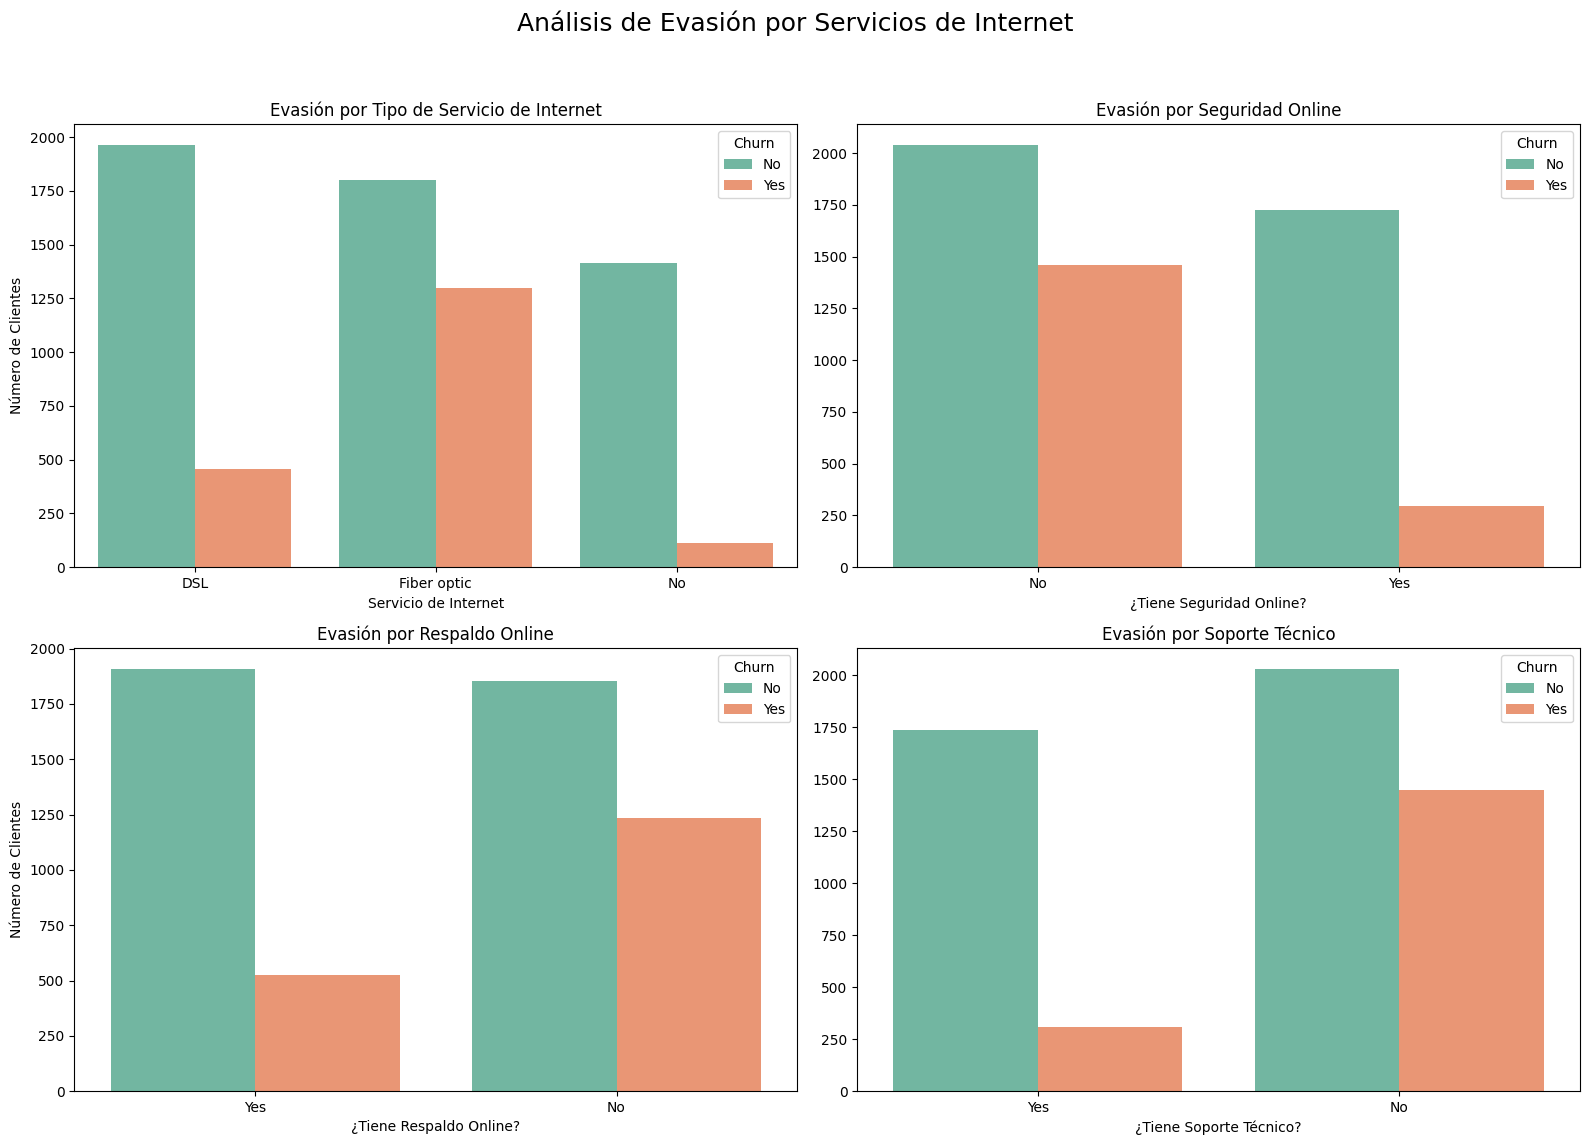

In [19]:
# Análisis por servicios contratados (Internet)
# Filtrar solo clientes con servicio de internet para analizar servicios adicionales
internet_customers = df_clean[df_clean['InternetService'] != 'No']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Análisis de Evasión por Servicios de Internet', fontsize=18)

# Tipo de Servicio de Internet
sns.countplot(ax=axes[0, 0], x='InternetService', hue='Churn', data=df_clean, palette='Set2')
axes[0, 0].set_title('Evasión por Tipo de Servicio de Internet')
axes[0, 0].set_xlabel('Servicio de Internet')
axes[0, 0].set_ylabel('Número de Clientes')

# Seguridad Online
sns.countplot(ax=axes[0, 1], x='OnlineSecurity', hue='Churn', data=internet_customers, palette='Set2')
axes[0, 1].set_title('Evasión por Seguridad Online')
axes[0, 1].set_xlabel('¿Tiene Seguridad Online?')
axes[0, 1].set_ylabel('')

# Respaldo Online
sns.countplot(ax=axes[1, 0], x='OnlineBackup', hue='Churn', data=internet_customers, palette='Set2')
axes[1, 0].set_title('Evasión por Respaldo Online')
axes[1, 0].set_xlabel('¿Tiene Respaldo Online?')
axes[1, 0].set_ylabel('Número de Clientes')

# Soporte Técnico
sns.countplot(ax=axes[1, 1], x='TechSupport', hue='Churn', data=internet_customers, palette='Set2')
axes[1, 1].set_title('Evasión por Soporte Técnico')
axes[1, 1].set_xlabel('¿Tiene Soporte Técnico?')
axes[1, 1].set_ylabel('')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

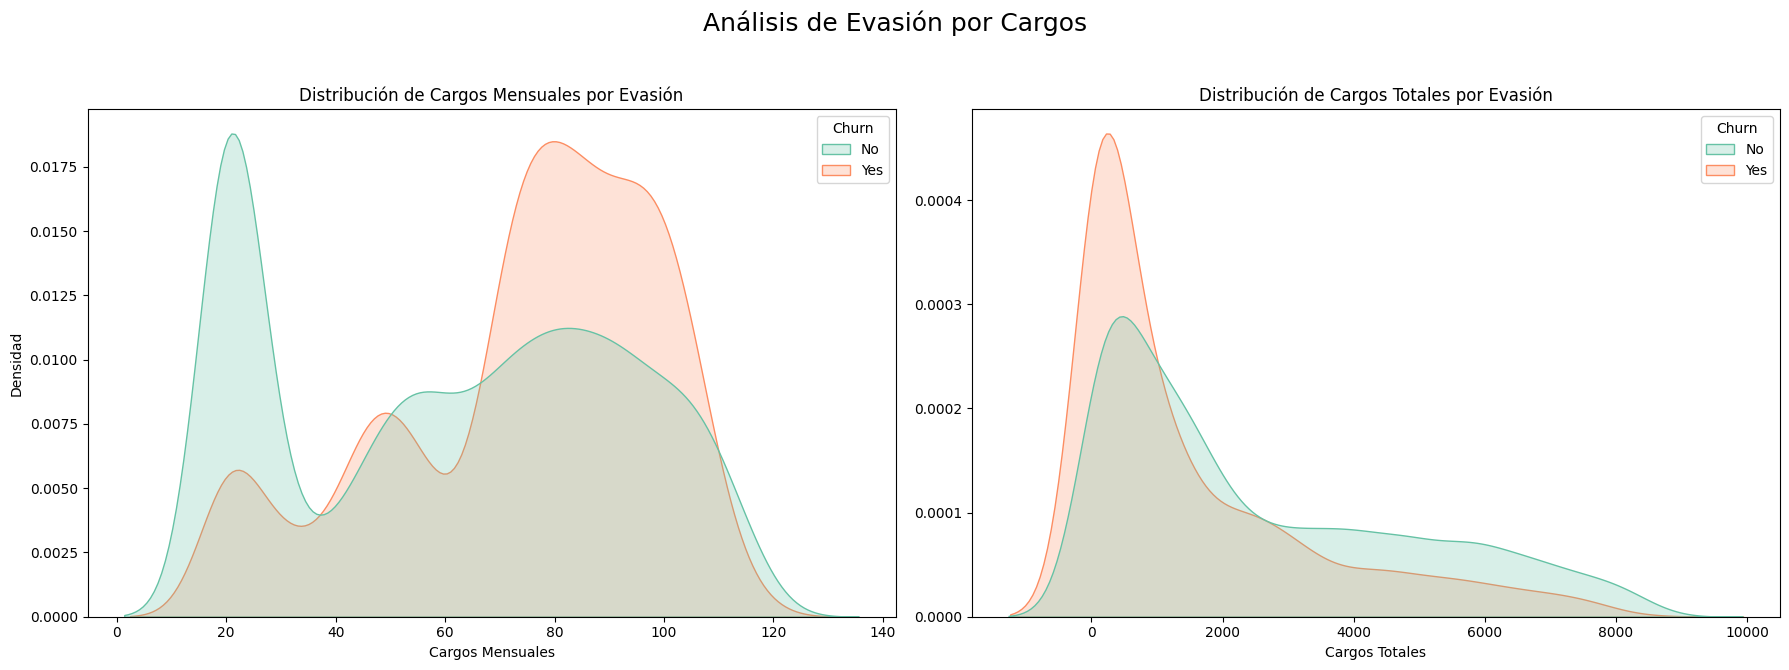

In [20]:
# Análisis por cargos mensuales y totales.
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Análisis de Evasión por Cargos', fontsize=18)

# Cargos Mensuales (MonthlyCharges)
sns.kdeplot(ax=axes[0], x='Charges.Monthly', hue='Churn', data=df_clean, fill=True, common_norm=False, palette='Set2')
axes[0].set_title('Distribución de Cargos Mensuales por Evasión')
axes[0].set_xlabel('Cargos Mensuales')
axes[0].set_ylabel('Densidad')

# Cargos Totales (TotalCharges)
sns.kdeplot(ax=axes[1], x='Charges.Total', hue='Churn', data=df_clean, fill=True, common_norm=False, palette='Set2')
axes[1].set_title('Distribución de Cargos Totales por Evasión')
axes[1].set_xlabel('Cargos Totales')
axes[1].set_ylabel('')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#📄Informe final

🔍 Conclusiones del Análisis Exploratorio

El análisis exploratorio de los datos ha permitido identificar factores clave asociados a la evasión de clientes en Telecom X. A partir de las visualizaciones y relaciones encontradas, se destacan las siguientes observaciones:

🧠 Principales Hallazgos

1. Tipo de Contrato

El tipo de contrato es el principal predictor de evasión. Los clientes con contratos mensuales (mes a mes) presentan tasas de cancelación significativamente más altas en comparación con aquellos con contratos anuales o bianuales.

2. Servicio de Internet

Los usuarios de fibra óptica muestran una mayor propensión a cancelar el servicio. Esto sugiere posibles problemas relacionados con la calidad, el precio o el desajuste entre expectativas y experiencia.

3. Método de Pago

El uso de cheque electrónico se asocia fuertemente con la evasión, lo que podría estar vinculado a la experiencia de pago o al perfil sociodemográfico de quienes utilizan este método.

4. Falta de Servicios Complementarios

Clientes que no contratan servicios de soporte técnico, seguridad online o respaldo en la nube presentan mayores tasas de cancelación, especialmente si cuentan con servicio de internet.

5. Cargos Mensuales Elevados

Se observa una concentración de cancelaciones en clientes con cargos mensuales cercanos a los $100, lo cual indica sensibilidad al precio o percepción de bajo valor recibido.

6. Perfil Demográfico

Los adultos mayores, así como los clientes solteros o sin dependientes, muestran una mayor probabilidad de abandonar el servicio.

💡 Recomendaciones

* Contratos y Servicios

Revisar el modelo de contratos mensuales, ya que concentran el mayor riesgo de cancelación.

Evaluar la experiencia de clientes con fibra óptica, especialmente en cuanto a precio, desempeño técnico y atención postventa.

Promover servicios complementarios (seguridad, respaldo, soporte técnico), que parecen actuar como factores de retención.

Analizar el impacto de múltiples líneas telefónicas, que presentan una ligera alza en la tasa de evasión.

* Facturación y Pagos

Monitorear clientes que usan facturación electrónica, quienes muestran mayor propensión a cancelar.

Revisar el proceso de pago mediante cheque electrónico, ya que es el método con mayor tasa de evasión.

Considerar planes diferenciados para cargos mensuales altos, ya que representan un segmento sensible a la evasión.

📈 Sugerencias para el Equipo de Ciencia de Datos

* Modelado Predictivo

Utilizar los factores identificados como variables predictoras en modelos supervisados (clasificación) para anticipar la probabilidad de cancelación de cada cliente.

* Ingeniería de Características

Crear variables compuestas que reflejen interacciones clave, como “contrato + método de pago”, o “servicio de internet + servicios adicionales contratados”.

* Análisis de Sentimiento

Si se dispone de encuestas de satisfacción, comentarios o transcripciones de llamadas, aplicar técnicas de procesamiento de lenguaje natural para identificar causas subjetivas de cancelación.
